In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

from utils import plot_kinematic_features

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from HiggsML.systematics import systematics
hep.style.use(hep.style.ATLAS)

path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

import os
os.chdir(f"{path_prefix}")

from HiggsML.datasets import download_dataset

In [5]:
data = download_dataset("https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip")

2025-06-05 13:00:56,659 - HiggsML.datasets     - INFO     - Handling as URL: https://zenodo.org/records/15131565/files/FAIR_Universe_HiggsML_data.zip
2025-06-05 13:00:56,660 - HiggsML.datasets     - INFO     - Current working directory: /data/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau
2025-06-05 13:00:56,720 - HiggsML.datasets     - INFO     - Total rows: 220099101
2025-06-05 13:00:56,721 - HiggsML.datasets     - INFO     - Test size: 66029730


In [6]:
# Assign an integer with each of the processes (same as the dictionary used to load)
labels_dict = {"htautau": 0,
              "ztautau":1,
              "ttbar":2}

# exclude low stats diboson sample for now
# labels_dict = {"htautau": 0,
#               "ztautau":1,
#               "ttbar":2,
#               "diboson":3}


# np.save(f"{saved_data}labels_dictionary.npy", labels_dict)


In [7]:
list_of_processes = list(labels_dict.keys())

In [8]:
data.load_train_set(train_size=0.05)
df_training = data.get_train_set()
del data

2025-06-05 13:01:03,861 - HiggsML.datasets     - INFO     - Selected train size: 7703468
2025-06-05 13:03:25,775 - HiggsML.datasets     - INFO     - Data loaded successfully


In [9]:
df_training['type'] = df_training['detailed_labels'].copy()

df_training['has_jets'] = np.where(
    df_training['PRI_n_jets'] > 0, 1, 0
)

In [10]:
mask_selected_processes = np.isin(df_training.detailed_labels.to_numpy(), list_of_processes)
df_training = df_training[mask_selected_processes].copy()

In [11]:
df_training.detailed_labels.unique()

array(['ztautau', 'htautau', 'ttbar'], dtype=object)

In [12]:
df_training['train_labels'] = -1 

for key in labels_dict:
    df_training.loc[df_training['detailed_labels'] == key, 'train_labels'] = labels_dict[key]


In [13]:
df_training.columns.unique()

Index(['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_had_pt', 'PRI_had_eta',
       'PRI_had_phi', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_n_jets',
       'PRI_jet_all_pt', 'PRI_met', 'PRI_met_phi', 'weights',
       'detailed_labels', 'labels', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_had_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_had', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'type', 'has_jets', 'train_labels'],
      dtype='object')

In [34]:
mask_selection = (df_training['PRI_lep_pt']<=200.0) & (df_training['PRI_met']<=250.0) & (df_training['PRI_had_pt']<=225.0) & (df_training['PRI_jet_all_pt']<=500.0)
df_training_selection = df_training[mask_selection].copy()


In [35]:
syst_settings = {
    'TES_up': {'tes': 1.02},
    'TES_dn': {'tes': 0.98},
    'JES_up': {'jes': 1.02},
    'JES_dn': {'jes': 0.98}
}

dataset_dict = {}

dataset_dict['nominal'] = systematics(
        data_set = df_training_selection,
        dopostprocess=True
        )

for sample_name, syst_args in syst_settings.items():
    dataset_dict[sample_name] = systematics(
        data_set = df_training_selection, 
        dopostprocess=True, 
        **syst_args
    )



In [36]:
input_features = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_jet_leading_eta', 'PRI_n_jets', 'has_jets']
columns_to_keep = input_features + ['weights', 'detailed_labels', 'type', 'train_labels']

for sample in dataset_dict:
    dataset_dict[sample] = dataset_dict[sample][columns_to_keep].copy()

In [37]:
# path prefix for saving cached data used between modules
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}cached_data/'


if not os.path.exists(saved_data):
    print(f"Making new directory for caching data {saved_data}")
    os.makedirs(saved_data)


In [38]:
for sample in dataset_dict: 
    dataset_dict[sample].to_hdf(f"{saved_data}df_{sample}.h5", key="dataset", mode="w")

In [39]:
import sys, importlib
importlib.reload(sys.modules['utils'])
from utils import plot_kinematic_features

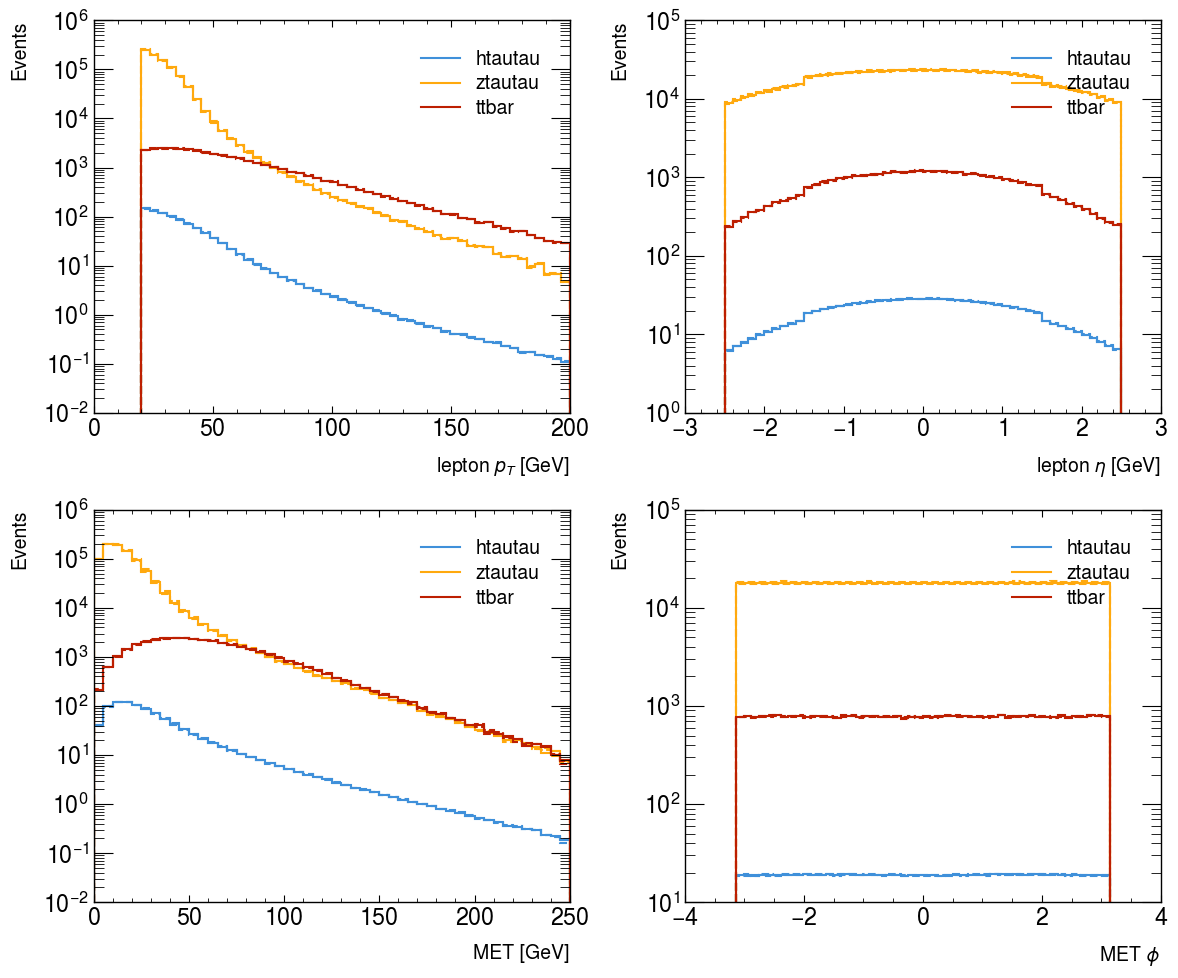

In [40]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()


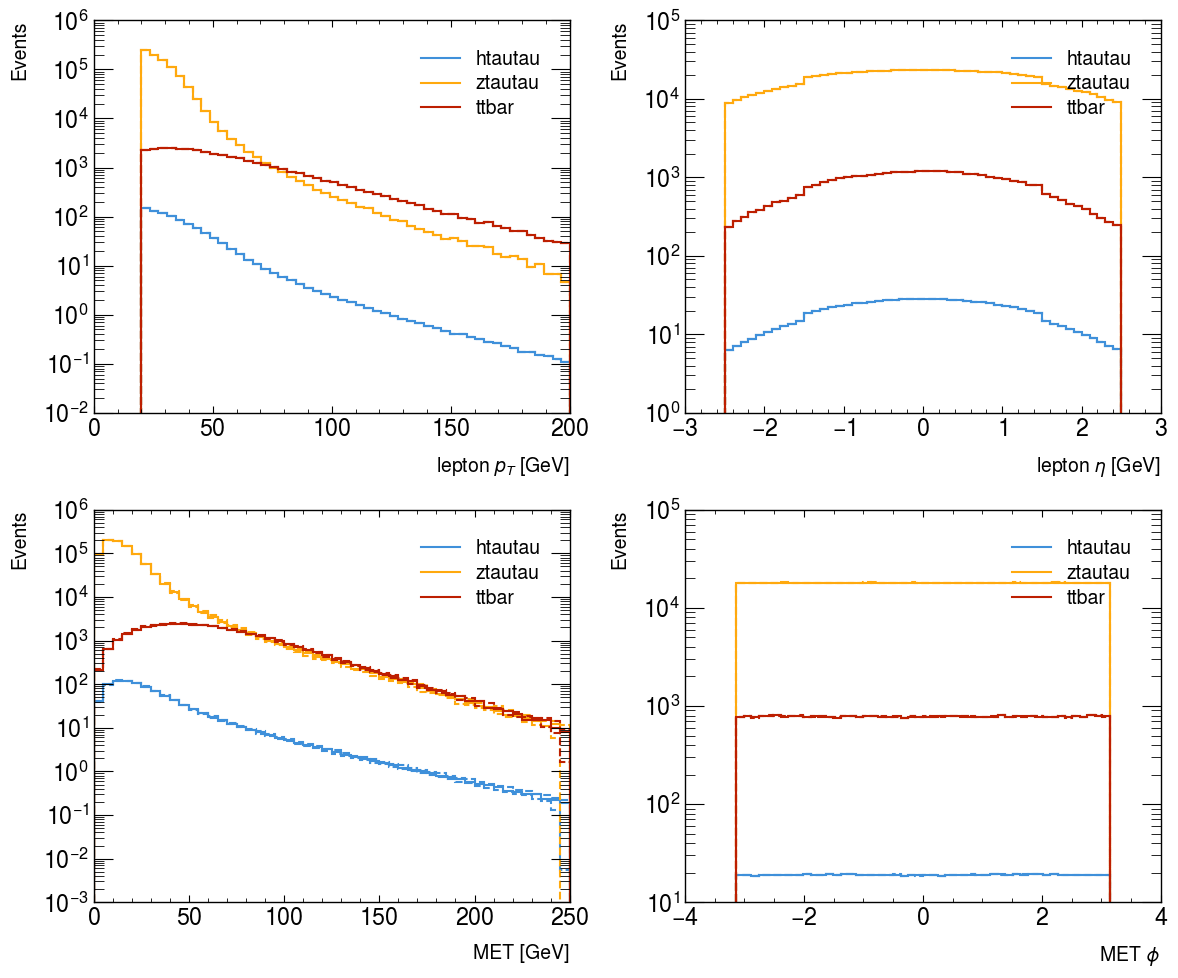

In [41]:
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi']
nbins = 50

xlabel_dict = {
    'PRI_lep_pt': 'lepton $p_T$ [GeV]', 
    'PRI_lep_eta': 'lepton $\\eta$ [GeV]', 
    'PRI_met': 'MET [GeV]', 
    'PRI_met_phi': 'MET $\\phi$',     
    'PRI_n_jets': '$n_{jets}$'      
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']


fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

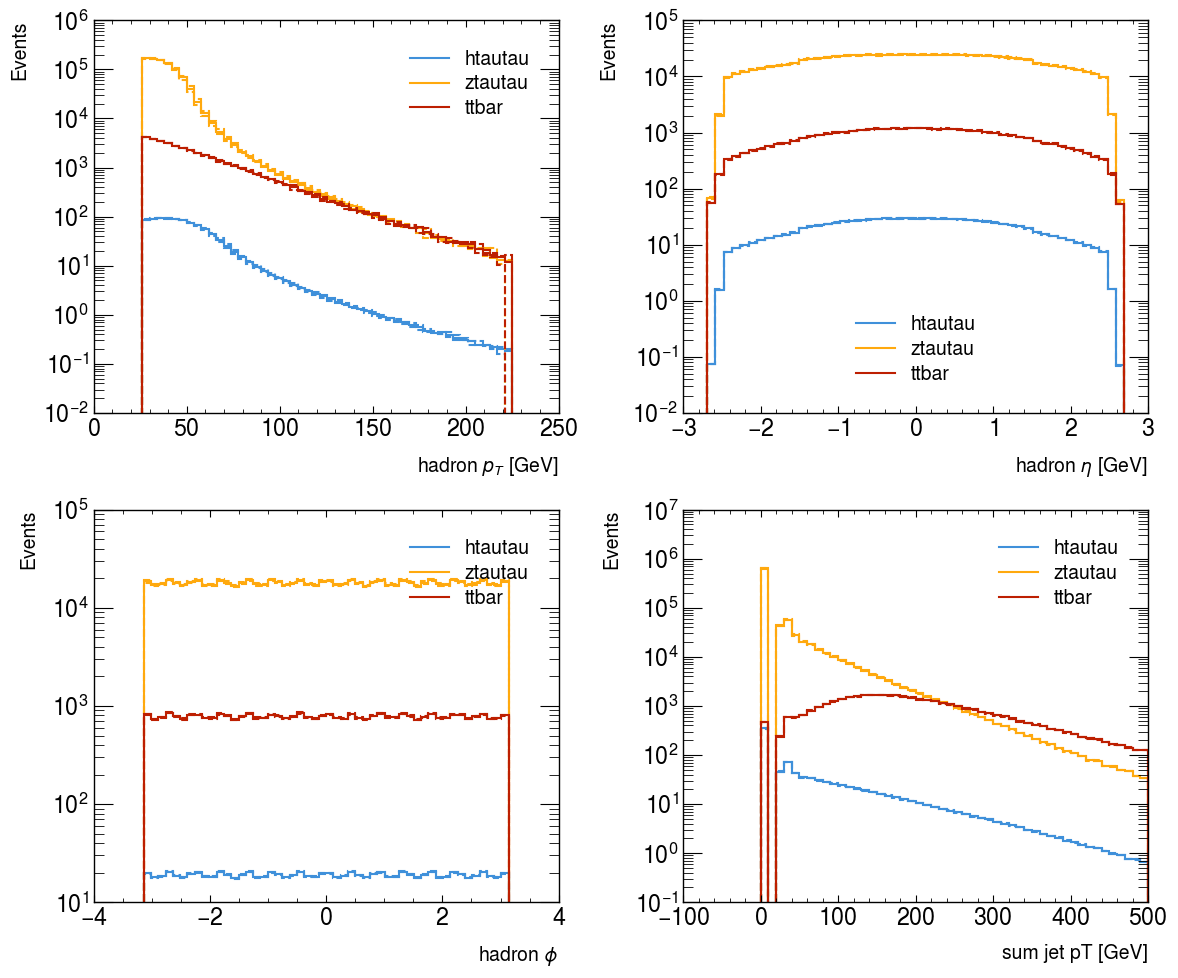

In [42]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'TES_up', 'TES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()

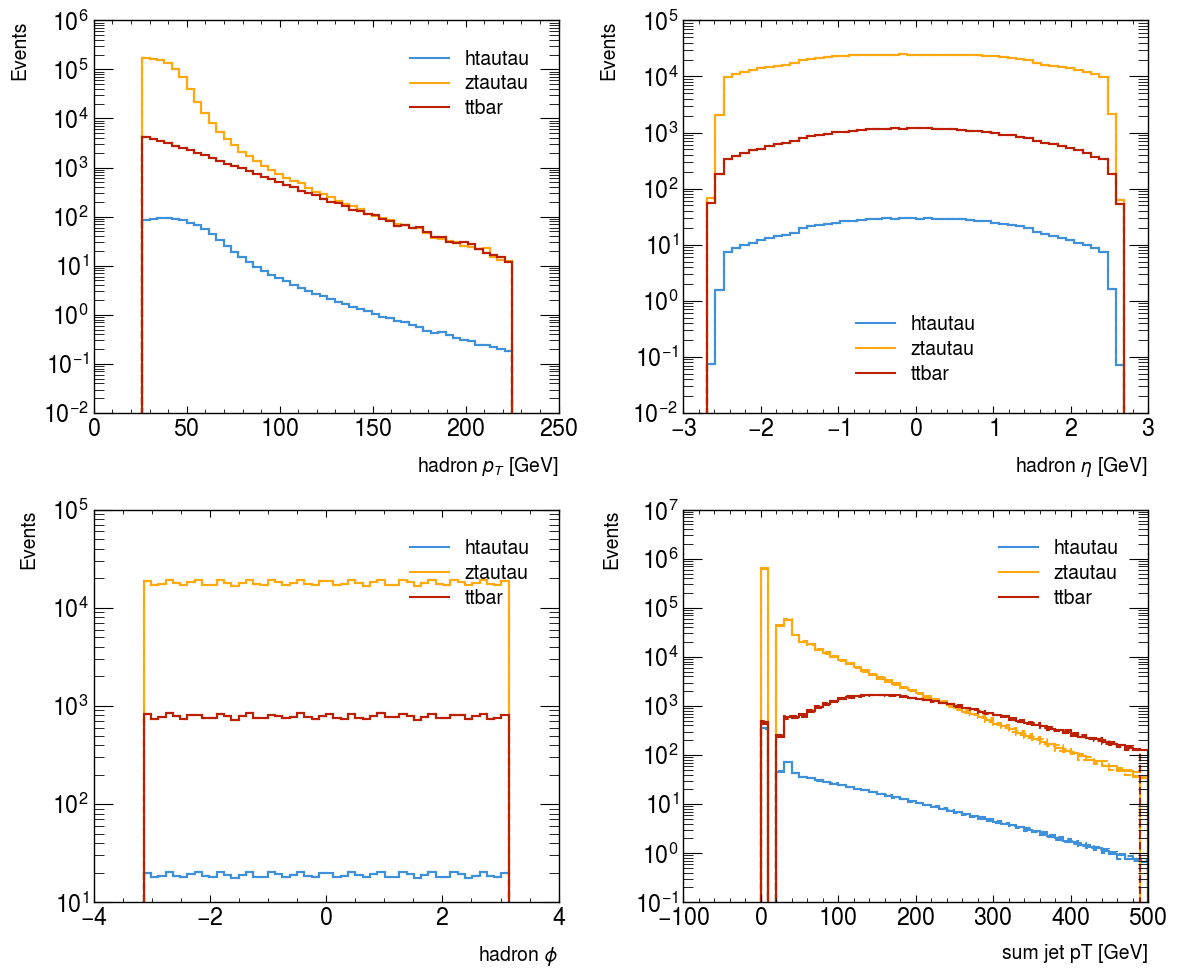

In [43]:
columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']
# columns = ['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
nbins = 50

xlabel_dict = {
    'PRI_had_pt': 'hadron $p_T$ [GeV]', 
    'PRI_had_eta': 'hadron $\eta$ [GeV]', 
    'PRI_had_phi': 'hadron $\phi$', 
    'PRI_jet_all_pt': 'sum jet pT [GeV]',
}

variations_to_plot = ['nominal', 'JES_up', 'JES_dn']

fig, axes = plot_kinematic_features(
    columns=columns,
    nbins=nbins,
    variations_to_plot=variations_to_plot,
    dataset_dict=dataset_dict,
    xlabel_dict=xlabel_dict,
    labels_dict=labels_dict
)
plt.show()